In [39]:
import pandas
import math

In [40]:
df = pandas.read_csv('company_directorships.csv')

df.software_background = df.software_background.map(lambda x: x == 't')
df.sample(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
11036,STAAR SURGICAL CO,718937,BARRY CALDWELL,False,2011-04-15,2014-05-05
284,AgEagle Aerial Systems Inc.,8504,DEDE P. JONES,False,2008-05-07,2008-05-07
4404,FIRST BUSEY CORP /NV/,314489,FREDERIC L. KENNEY,False,2019-04-11,2024-04-12
11152,STEPAN CO,94049,JAN STERN REED,False,2016-03-24,2025-03-25
9546,PFIZER INC,78003,"SUSAN DESMOND-HELLMANN, M.D., M.P.H.",True,2021-03-12,2022-03-17


In [41]:
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()


# TASK 2 CHANGE 1
# This common gender function ignores the edge case of if the gender split is equal
# def most_common(series):
#    mode_values = series.mode()
#    if len(mode_values) > 0:
#        return mode_values[0]
#    return None

# This function accounts for male and female both having the same amount, and returns 'Multiple'
def most_common(series):
    mode_values = series.mode()
    if len(mode_values) == 1:
        return mode_values[0]
    elif len(mode_values) > 1:
        return 'Multiple'
    return None
    
compensation_and_demographics = pandas.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)
})
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [42]:
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [43]:
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

director_name
A CHARLENE SULLIVAN, PH.D.     1
MICHAEL L. KUTA                1
MICHAEL L. LARUSSO             1
MICHAEL L. MILLER              1
MICHAEL L. OWENS               1
                              ..
MARTIN L. FLANAGAN            13
ANN BARNETT STERN             13
TERESA M. RESSEL              13
BRUCE L. CROCKETT             13
ALBERT R. DOWDEN              14
Name: company_name, Length: 11827, dtype: int64

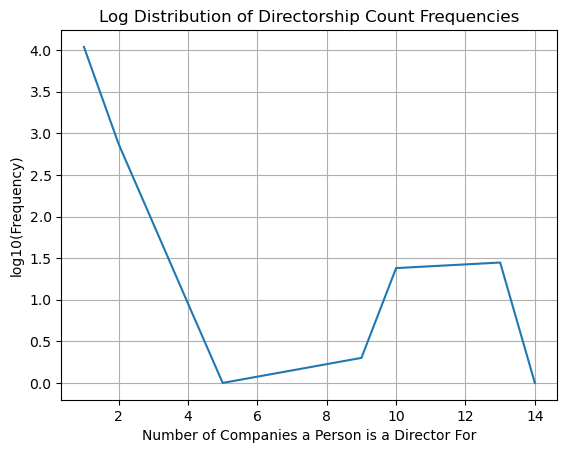

In [85]:
# TASK 2 CHANGE 2d
# This plot has no labelling in it, and is confusing and ill-described
# directorship_counts.value_counts().sort_index().map(math.log10).plot()

# Below is added labels and a log scale to better showcase the data

import matplotlib.pyplot as plt

directorship_counts.value_counts().sort_index().map(math.log10).plot()

plt.title("Log Distribution of Directorship Count Frequencies")
plt.xlabel("Number of Companies a Person is a Director For")
plt.ylabel("log10(Frequency)")
plt.grid(True)
plt.show()


In [45]:
import networkx
import networkx.algorithms
graph = networkx.Graph()

In [46]:
people = []
companies = []
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

In [47]:
# TASK 2 CHANGE 3
# This assumes the biggest connected graph is simply the first in the array, however 
# networkx.connect_components returns an unordered set of sets. 
# biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])

# This change ensures you always receive the biggest connected component
largest_cc = max(networkx.connected_components(graph), key=len)
biggest_connected_graph = graph.subgraph(largest_cc)


In [48]:
%%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
    # BELOW IS THE ADDED LINE OF CODE FOR TASK 1
    # Kernel took 430 seconds to process this
    'betweenness': pandas.Series(networkx.betweenness_centrality(biggest_connected_graph)),

})
centrality['is_person'] = centrality.index.map(lambda x: x in people)

CPU times: user 7min 8s, sys: 1.33 s, total: 7min 9s
Wall time: 7min 14s


In [49]:
# TASK 2 CHANGE 4
# In the case that one of the values here is missing, that data point gets silently dropped due to left and right
# index needing to be true.
# people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

# Below a how='left' check occurs to make sure pandas won't default to 'inner' so that the left dataframe (centrality)
# is kept regardless of if there is a value in the right dataframe (demographic data)

# Merge with warning in case of dropped data
people_df = centrality[centrality.is_person].merge(
    compensation_and_demographics, left_index=True, right_index=True, how='left'
)

# Check for missing values after merge
missing_data = people_df[people_df['age'].isna()]
if not missing_data.empty:
    print("Warning: Some people have no demographic data.")

In [50]:
people_df.sort_values('eigen', ascending=False)

,eigen,degree,betweenness,is_person,age,compensation,gender,log_compensation
ELIZABETH KRENTZMAN,1.024389e-01,0.001585,1.394057e-07,True,65,3408245,female,6.532531
CAROL DECKBAR,1.024389e-01,0.001585,1.394057e-07,True,62,43263,female,4.636127
ELI JONES,1.024389e-01,0.001585,1.394057e-07,True,63,3063255,male,6.486183
DOUGLAS SHARP,1.024389e-01,0.001585,1.394057e-07,True,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",1.024389e-01,0.001585,1.394057e-07,True,65,27531,male,4.439838
...,...,...,...,...,...,...,...,...
JOHN J. GEBBIA,8.400282e-35,0.000122,0.000000e+00,True,86,120000,male,5.079185
ANDREW S. BORODACH,8.342633e-35,0.000122,0.000000e+00,True,56,0,male,0.000000
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,0.000000e+00,True,91,30356,male,4.482259
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,0.000000e+00,True,70,50356,female,4.702060


In [51]:
df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [52]:
import sklearn.cluster

In [53]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [54]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

cluster_id
 1    3117
 0     385
 2     109
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='log_compensation'>

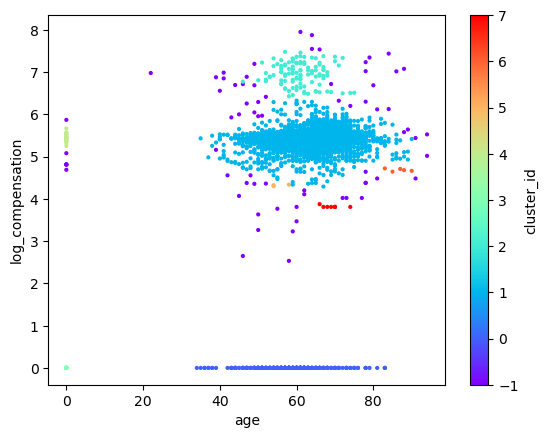

In [55]:
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [56]:
people_df.loc['ELIZABETH KRENTZMAN']

eigen               0.102439
degree              0.001585
betweenness              0.0
is_person               True
age                       65
compensation         3408245
gender                female
log_compensation    6.532531
cluster_id                 2
Name: ELIZABETH KRENTZMAN, dtype: object